
<h2> ‎ </h2>
<h2><center>Procesamiento Digital de Imágenes</center></h2>
<h2><center>Morfología y segmentación de imagenes</center></h2>
<h2><center>Luis David Huante</center></h2>
<h2><center>A 11 de diciembre de 2023</center></h2>

## Introducción

<p style="text-align:justify;">
La morfología y la segmentación de imágenes son dos disciplinas esenciales en el campo de la visión por computadora que desempeñan un papel fundamental en numerosas aplicaciones médicas y científicas. En particular, la segmentación de vasos sanguíneos se ha convertido en un área de investigación crítica en la medicina y la biología, ya que puede proporcionar información crucial para el diagnóstico y tratamiento de enfermedades vasculares, como la retinopatía diabética y la arteriosclerosis. La capacidad de identificar y aislar con precisión los vasos sanguíneos en imágenes médicas es esencial para mejorar la detección temprana de enfermedades, lo que a su vez puede llevar a tratamientos más efectivos y a una mejor calidad de vida para los pacientes.
</p>

<p style="text-align:justify;">
En esta tarea, exploraremos en detalle las técnicas relacionados con la morfología y la segmentación de imágenes aplicados específicamente a la tarea de segmentación de vasos sanguíneos. Examinaremos cómo la morfología puede ayudar a realzar y simplificar la estructura de los vasos sanguíneos en imágenes médicas, y cómo las técnicas de segmentación permiten la extracción automática y precisa de los vasos de interés. Este proceso puede ser crucial en la investigación médica y la práctica clínica, ya que puede ayudar a los profesionales de la salud a detectar y tratar enfermedades vasculares de manera más efectiva, mejorando así la atención médica en general.


Se llevarán a cabo dos etapas cruciales para la segmentación de vasos sanguíneos en imágenes médicas. En primer lugar, se realizará un proceso de preprocesamiento de la imagen, que implica mejorar las características importantes y reducir el ruido utilizando operaciones morfológicas. En segundo lugar, se llevará a cabo la fase de segmentación, donde el algoritmo deberá preservar en una imagen en escala de grises únicamente las estructuras de interés, es decir, los vasos sanguíneos.
</p>


## Código

Importamos las librerías correspondientes.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile

La función `minimum_filter` aplica un filtro de erosión a una imagen I utilizando un elemento estructurante rectangular de tamaño `k_shape` x `k_shape`. Este proceso típicamente reduce el brillo de los píxeles, enfatizando las regiones más oscuras de la imagen.

In [ ]:
def minimum_filter(I, k_shape):
    return cv2.erode(I, cv2.getStructuringElement(cv2.MORPH_RECT, (k_shape, k_shape)))

**CLAHE (Contrast Limited Adaptive Histogram Equalization)**: Es una técnica para mejorar el contraste de las imágenes. A diferencia del ecualizador de histograma normal, CLAHE realiza la ecualización de forma adaptativa en diferentes partes de la imagen, limitando el contraste para evitar la amplificación del ruido.

La función clahe que aplica CLAHE a una imagen I, utilizando un tamaño de bloque k_size y un límite de contraste clip_lim.

In [ ]:
def clahe(I, k_size, clip_lim):
    return cv2.createCLAHE(clipLimit=clip_lim, tileGridSize=(k_size, k_size)).apply(I)

Leemos las imagenes necesarias:

In [ ]:
images = [cv2.imread(f'Input_Images/image{str(i).zfill(3)}.png') for i in range(1, 91)]

### Preprocesamiento

En el análisis de las imágenes recopiladas, se observó que el canal verde parecía ser particularmente útil para nuestros propósitos. Esta tendencia es notable, especialmente porque el canal verde a menudo contiene información valiosa sobre la luminosidad y los detalles finos de una imagen. En el espectro de colores que maneja la visión humana, el verde se encuentra en un punto medio que suele ser crucial para resaltar ciertas características y patrones en las imágenes.

In [ ]:
first_image = images[0]  # Obtener la primera imagen

green_channel = first_image[:, :, 1]  # Extraer el canal verde

TypeError: ignored

In [ ]:
plt.imshow(green_channel,'gray')

NameError: ignored

El preprocesamiento implicó, inicialmente, la aplicación de un filtro mínimo utilizando un kernel de tamaño 7×7. Esta elección se basó en varios experimentos que demostraban que un kernel de 7×7 ofrecía resultados superiores en comparación con otros tamaños. Posteriormente, se aplicó el método CLAHE (Contrast Limited Adaptive Histogram Equalization) con un kernel de tamaño 50 y un límite de contraste establecido en 2. Este enfoque combinado aseguró un equilibrio óptimo entre la realce del contraste y la preservación de detalles.

In [ ]:
bordered = clahe(minimum_filter(green_channel,7), 50, 2)

El kernel seleccionado está diseñado para resaltar o modificar ciertas características de la imagen, como contornos o bordes.

In [ ]:
kernel = np.array([[0,0,1,0,0],[0,0,1,0,0],[1,1,1,1,1],[0,0,1,0,0],[0,0,1,0,0]],np.uint8)

Para eliminar el fondo de una imagen, se umbraliza con un valor muy bajo, ya que generalmente el fondo en las imágenes es negro. Después de realizar varios experimentos, se determinó que un umbral de 4 es adecuado para separar únicamente el fondo negro de la imagen. Se aplica una umbralización inversa para que el fondo se represente como píxeles con valor 1.

In [ ]:
background = cv2.dilate(cv2.threshold(bordered,4,1,cv2.THRESH_BINARY_INV)[1],kernel,iterations=1)
background = (background*bordered.mean()).astype(np.uint8)

El resultado es el siguiente:

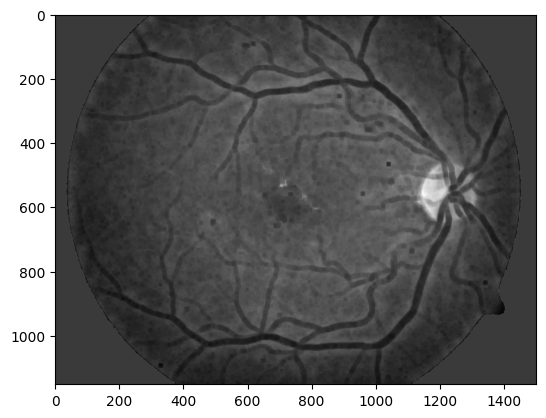

In [ ]:
plt.imshow(bordered+background,'gray')

## Algoritmo

El proceso final del algoritmo se desarrolla a través de una serie de pasos secuenciales, que son los siguientes:

1. Implementar un filtro mínimo.
2. Utilizar el método `CLAHE` para la ecualización adaptativa del histograma.
3. Eliminar el fondo de la imagen.
4. Realizar la umbralización adaptativa.
5. Aplicar nuevamente el filtro mínimo.
6. Proceder con la dilatación de la imagen.
7. Ejecutar la técnica de apertura en dos iteraciones sucesivas.
8. Llevar a cabo la erosión de la imagen.
9. Combinar la imagen en escala de grises con la máscara obtenida en el paso anterior mediante una operación de multiplicación.

### Funciones

La función `background_remover` toma una imagen I (como un arreglo de NumPy) y un kernel como argumentos. Primero, binariza la imagen con un límite muy bajo, creando una máscara invertida. Luego, dilata esta máscara y multiplica la imagen original por la media de sus valores, sumando esta operación a la imagen original. El objetivo es remover el fondo de la imagen, sustituyéndolo por el valor medio de la imagen.

In [ ]:
def background_remover(I: np.array, kernel):
    # Binarizar y dilatar
    dilated_mask = cv2.dilate(cv2.threshold(I, 4, 1, cv2.THRESH_BINARY_INV)[1], kernel, iterations=1).astype(np.uint8)
    # Remover fondo
    return (I + dilated_mask * I.mean()).astype(np.uint8)

La función `segmentation_mask `se usa para generar una máscara de segmentación de una imagen I. Comienza aplicando un filtro mínimo y el método CLAHE para mejorar el contraste. Luego, se remueve el fondo y se aplica umbralización adaptativa. Finalmente, realiza una serie de operaciones morfológicas: dilatación, apertura y erosión, para refinar la máscara resultante.

In [ ]:
def segmentation_mask(I: np.array, k_min, k_clahe, clipl_clahe, adpt_lim=71):
    # Preprocesamiento
    preproc = background_remover(clahe(minimum_filter(I, k_min), k_clahe, clipl_clahe), kernel)
    adaptive_thld = cv2.adaptiveThreshold(preproc, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, adpt_lim, 1)

    # Operaciones morfológicas
    morph_ops = cv2.morphologyEx(minimum_filter(adaptive_thld, 9), cv2.MORPH_DILATE, kernel, iterations=1)
    morph_ops = cv2.morphologyEx(morph_ops, cv2.MORPH_OPEN, kernel, iterations=2)
    return cv2.morphologyEx(morph_ops, cv2.MORPH_ERODE, kernel, iterations=1)

La función `segmentation` se utiliza para segmentar una imagen I. Inicialmente, genera una máscara de segmentación utilizando solo el canal verde de la imagen (I[:,:,1]) y parámetros específicos. Posteriormente, multiplica esta máscara por la imagen original convertida a escala de grises, lo que resulta en una versión segmentada de la imagen.

In [ ]:
def segmentation(I: np.array, k_min, k_clahe, clipl_clahe, adpt_lim=71):
    return cv2.cvtColor(I, cv2.COLOR_BGR2GRAY) * segmentation_mask(I[:,:,1], k_min, k_clahe, clipl_clahe, adpt_lim)

### Ejemplo

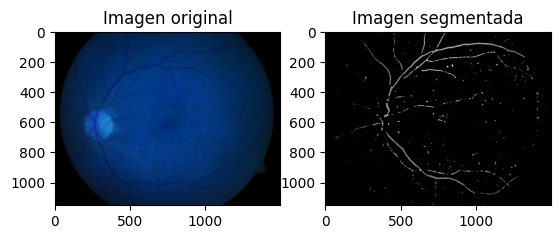

In [ ]:
# Visualización de resultado
plt.subplot(121)
plt.imshow(images[1])
plt.title('Imagen original')
plt.subplot(122)
plt.imshow(segmentation(images[11],7,50,2),'gray')
plt.title('Imagen segmentada')
plt.show()

## Resultados

Como parte de los resultados, es necesario crear un directorio `Output_Images `para agregar las imagenes.

In [ ]:
!mkdir Output_Images

Se realiza la segmentación de cada una de las imágenes y se guardan en el directorio `Output_Images` con el mismo nombre que la imagen original.

En algunos casos ciertas imagenes no cargaban, por lo que se decidió omitirlas.

In [ ]:
for i, img in enumerate(images):
    try:
        cv2.imwrite(f'Output_Images/image{str(i).zfill(3)}.png', segmentation(img, 7, 50, 2))
    except cv2.error as e:
        if "(-215:Assertion failed) !_src.empty() in function 'cvtColor'" in str(e):
            print(f"Error en la imagen {i}: la imagen está vacía o no se pudo cargar.")
            continue
        else:
            raise


Error en la imagen 72: la imagen está vacía o no se pudo cargar.
Error en la imagen 78: la imagen está vacía o no se pudo cargar.
Error en la imagen 89: la imagen está vacía o no se pudo cargar.


Descargamos la carpeta con las imagenes

In [ ]:
import os
import zipfile
from google.colab import files as colab_files

In [ ]:
def download_folder_from_colab(folder_name):
    # Se comprime la carpeta en un archivo ZIP
    zip_file = f"{folder_name}.zip"
    with zipfile.ZipFile(zip_file, 'w') as zipf:
        for root, dirs, file_list in os.walk(folder_name):
            for file in file_list:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_name))

    colab_files.download(zip_file)

# Uso de la función para descargar la carpeta 'Output_Files'
download_folder_from_colab('Output_Files')

NameError: ignored

## Conclusiones


Este proyecto resultó ampliamente útil para la aplicación de la segmentación de imágenes, integrando técnicas avanzadas de procesamiento y análisis de imágenes. La implementación del filtro mínimo, CLAHE, y la umbralización adaptativa ha mejorado notablemente la claridad y la precisión en la identificación de características clave en las imágenes. Estas mejoras han permitido una segmentación más detallada y eficiente, lo cual es crucial en aplicaciones donde la precisión del detalle es fundamental.

En el contexto más amplio del procesamiento de imágenes, este proyecto demuestra cómo la manipulación y el análisis de imágenes digitales a través de técnicas computacionales pueden tener un impacto significativo. La adquisición de imágenes desde varias fuentes es solo el comienzo; el preprocesamiento esencial que incluye la corrección de color, la reducción de ruido y el ajuste de contraste, prepara el camino para procesos más avanzados como la segmentación y la detección de características. Estos pasos son fundamentales para facilitar un análisis detallado, aprovechando tecnologías como el aprendizaje automático y la visión por computadora, lo que refleja la importancia y la utilidad de este proyecto en el campo más amplio del procesamiento de imágenes.

Un área particularmente beneficiada por estas técnicas avanzadas es la segmentación de vasos sanguíneos en imágenes médicas. La habilidad de distinguir con precisión los vasos sanguíneos de su entorno es crucial en el diagnóstico y tratamiento de diversas condiciones médicas. La precisión mejorada en la segmentación permite a los profesionales de la salud identificar patrones anormales y cambios en los vasos sanguíneos de manera más eficaz. Esta capacidad es especialmente valiosa en especialidades como la oftalmología y la cardiología, donde una identificación exacta de los vasos puede ser vital para el diagnóstico temprano y la prevención de enfermedades. En este sentido, la segmentación de imagenes no solo es una herramienta poderosa en el procesamiento general de imágenes, sino también un recurso invaluable en el ámbito de la imagenología médica, marcando un avance significativo en la medicina diagnóstica.